In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



In [2]:
os.chdir('..')

In [3]:
!pwd

/Users/alexey_imac/Documents/Data_Science_Immersive_Galvanize/ALEXEY_DATA/CAPSTONES/C2_PROJECT


In [4]:
batch_size = 32
img_height = 360 #180
img_width = 360 #180

In [5]:
# https://keras.io/api/preprocessing/image/
# Image data preprocessing
# image_dataset_from_directory function
# tf.keras.preprocessing.image_dataset_from_directory(
#     directory,
#     labels="inferred",
#     label_mode="int",
#     class_names=None,
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(256, 256),
#     shuffle=True,
#     seed=None,
#     validation_split=None,
#     subset=None,
#     interpolation="bilinear",
#     follow_links=False,
#     crop_to_aspect_ratio=False,
#     **kwargs
# )
# https://www.tensorflow.org/tutorials/images/classification
# If your directory structure is:
# main_directory/
# ...class_a/
# ......a_image_1.jpg
# ......a_image_2.jpg
# ...class_b/
# ......b_image_1.jpg
# ......b_image_2.jpg
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'KERAS_data/TRAIN/YOGA_CLASSES_6',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False)
# , crop_to_aspect_ratio=False)
# TypeError: image_dataset_from_directory() got an unexpected keyword argument 'crop_to_aspect_ratio'
# Found 15636 files belonging to 6 classes.
# [34]:
# before train_ds = tf.keras.... <BatchDataset shapes: ((None, 20, 20, 1), (None,)), types: (tf.float32, tf.int32)>

Found 15636 files belonging to 6 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)
current_number_of_classes = len(train_ds.class_names)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory = 'KERAS_data/TEST/YOGA_CLASSES_6',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="grayscale",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False)

Found 5327 files belonging to 6 classes.


In [8]:
class_names = test_ds.class_names
print(class_names)

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5']


## Generates a tf.data.Dataset from image files in a directory.

    If your directory structure is:
    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg

Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

Supported image formats: jpeg, png, bmp, gif. Animated gifs are truncated to the first frame.

Visualize the data
https://www.tensorflow.org/tutorials/images/classification#visualize_the_data
Here are the first 9 images from the training dataset.

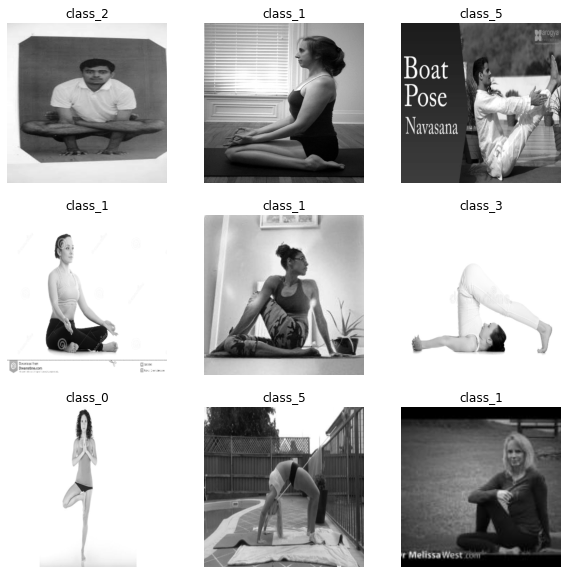

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 360, 360, 1)
(32,)


The image_batch is a tensor of the shape 
(32, 50, 50, 1)
(batch_size, img_height, img_width, gray). 
This is a batch of 32 images of shape 50x50x1 (the last dimension refers to gray channel). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [11]:
# https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

https://www.tensorflow.org/tutorials/images/classification#standardize_the_data
#  Standardize the data
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the [0, 1] range by using a Rescaling layer.

# Create the model
The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a relu activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach.

In [12]:
num_classes = current_number_of_classes
# input_shape=(img_height, img_width, 3) ==> , 1)
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [13]:
# https://www.tensorflow.org/tutorials/images/classification#compile_the_model
# For this tutorial, choose the optimizers.Adam optimizer and 
# losses.SparseCategoricalCrossentropy loss function. 
# To view training and validation accuracy for each training epoch, pass the metrics argument.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
# https://stackoverflow.com/questions/65592028/valueerror-being-thrown-this-model-has-not-been-built-for-cnn-audio-spectrog 
#  You have to build your model with your input shape before calling model.summary():
model.build((img_height, img_width))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 360, 360, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 360, 360, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 180, 180, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 45, 45, 64)        0

In [15]:
# import matplotlib.pyplot as plt
font_size = 20
plt.rc('font', size=font_size) #controls default text size
plt.rc('axes', titlesize=font_size) #fontsize of the title
plt.rc('axes', labelsize=font_size) #fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size) #fontsize of the x tick labels
plt.rc('ytick', labelsize=font_size) #fontsize of the y tick labels
plt.rc('legend', fontsize=font_size) #fontsize of the legend

In [16]:
# https://stackoverflow.com/questions/54527760/using-tensorflow-how-do-i-find-the-time-taken-for-an-epoch-during-fitting
# Model training duration visualization
from datetime import datetime

class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.epochs = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = tf.timestamp()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append(tf.timestamp() - self.timetaken)
        self.epochs.append(epoch)
    def on_train_end(self,logs = {}):

        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot(111)
        
        plt.title('Model trainig time for\n' + str(img_height) + 'x' + str(img_width) + ' images')
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(np.array(self.epochs)+1, self.times, 'ro')
        plt.xticks(np.arange(1, self.epochs[-1]+2, step=1.0)) # need last+1, range excludes last => +2
        epochs_times = []
        for i in range(len(self.epochs)):
          j = self.times[i].numpy()
          if i == 0:
            plt.text(i+1, j, str(round(j, 3)))
            epochs_times.append(round(j, 3))
          else:
            j_prev = self.times[i-1].numpy()
            plt.text(i+1, j, str(round(j-j_prev, 3)))
            epochs_times.append(round(j-j_prev, 3))
        
        # put total and mean per epoch in the upper left corner of the graph
        summary_text = (str(round(self.times[-1].numpy()/60,1)) + 
                        ' minutes total,\nfor ' + str(self.epochs[-1]+1) + ' epochs,\n~ ' + 
                        str(round(np.mean(epochs_times),1)) + ' sec / epoch')
        plt.text(0.2, 0.9, summary_text, horizontalalignment='center',
                 verticalalignment='center', 
                 transform=ax.transAxes, 
                 bbox=dict(facecolor='w', alpha=0.9))
        plt.grid(which='major', axis='both')
        
        img_file_name = 'presentation/Epochs_for_' + str(img_height) + 'x' + str(img_width) + '_images.png'
        plt.savefig(img_file_name, facecolor='w', edgecolor='w', format='png', transparent=False, pad_inches=0.1)
#         plt.savefig(datetime.now().strftime("%Y%m%d%H%M%S") + ".png")
# model.fit(train_images, train_labels, epochs=5,callbacks = [timecallback()])

Epoch 1/10
489/489 [==============================] - 527s 977ms/step - loss: 1.9566 - accuracy: 0.2970 - val_loss: 1.5005 - val_accuracy: 0.4194
Epoch 2/10
489/489 [==============================] - 447s 913ms/step - loss: 1.3695 - accuracy: 0.4779 - val_loss: 1.4519 - val_accuracy: 0.4672
Epoch 3/10
489/489 [==============================] - 446s 912ms/step - loss: 1.0135 - accuracy: 0.6223 - val_loss: 1.4758 - val_accuracy: 0.4836
Epoch 4/10
489/489 [==============================] - 446s 912ms/step - loss: 0.5316 - accuracy: 0.8181 - val_loss: 1.9265 - val_accuracy: 0.4907
Epoch 5/10
489/489 [==============================] - 446s 912ms/step - loss: 0.1969 - accuracy: 0.9430 - val_loss: 2.7960 - val_accuracy: 0.4879
Epoch 6/10
489/489 [==============================] - 449s 917ms/step - loss: 0.0879 - accuracy: 0.9745 - val_loss: 3.5488 - val_accuracy: 0.4704
Epoch 7/10
489/489 [==============================] - 448s 916ms/step - loss: 0.0819 - accuracy: 0.9786 - val_loss: 4.1092 -

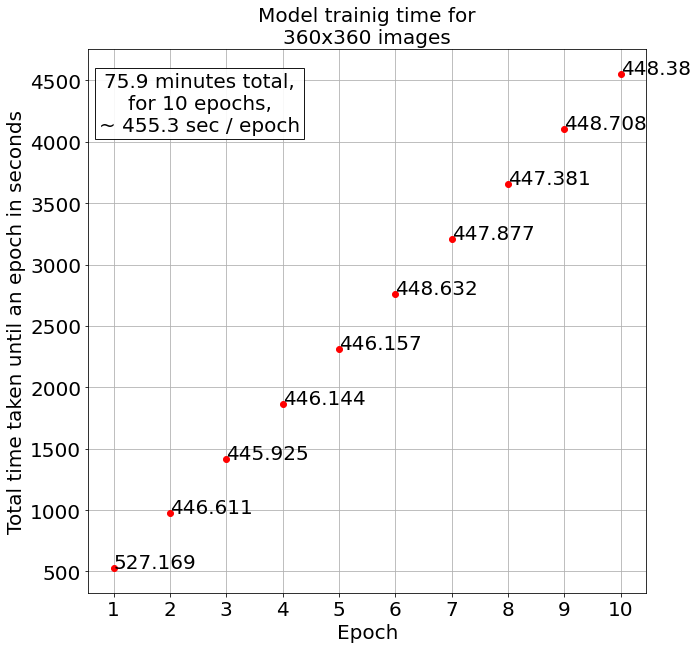

In [17]:
# https://www.tensorflow.org/tutorials/images/classification#train_the_model

epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=test_ds,
#   epochs=epochs
# )
history = model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=epochs,
  callbacks = [timecallback()]
)

In [18]:
# import matplotlib.pyplot as plt
font_size = 20
plt.rc('font', size=font_size) #controls default text size
plt.rc('axes', titlesize=font_size) #fontsize of the title
plt.rc('axes', labelsize=font_size) #fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size) #fontsize of the x tick labels
plt.rc('ytick', labelsize=font_size) #fontsize of the y tick labels
plt.rc('legend', fontsize=font_size) #fontsize of the legend

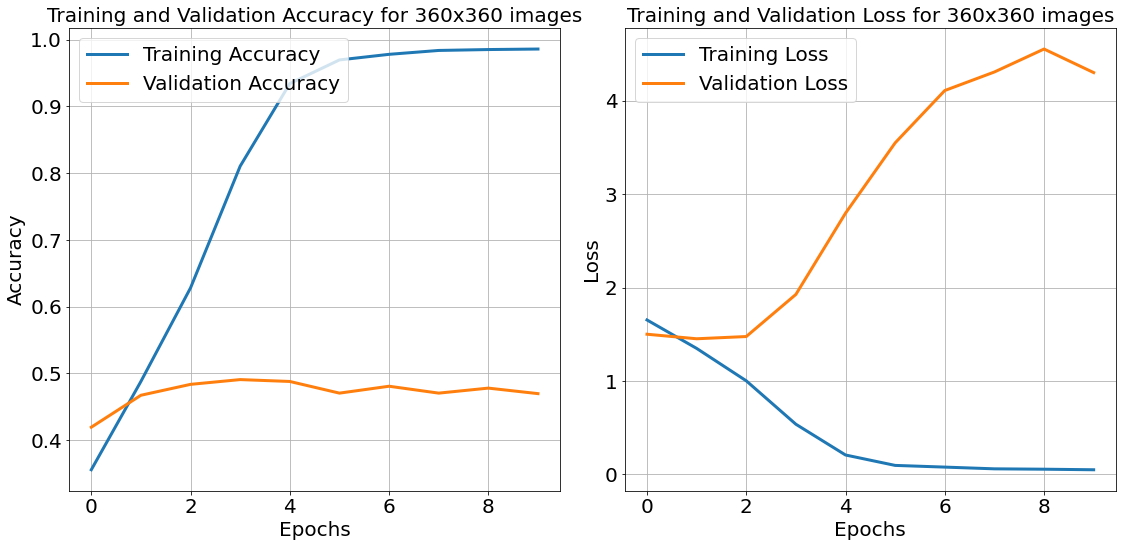

In [19]:
# https://www.tensorflow.org/tutorials/images/classification#visualize_training_results
# Create plots of loss and accuracy on the training and validation sets.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

line_width = 3
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=line_width)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=line_width)
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title(f'Training and Validation Accuracy for {img_height}x{img_width} images')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=line_width)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=line_width)
plt.legend(loc='upper left')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title(f'Training and Validation Loss for {img_height}x{img_width} images')
plt.grid()
plt.tight_layout()
img_file_name = 'presentation/performance_for_' + str(img_height) + 'x' + str(img_width) + 'images.png'
plt.savefig(img_file_name, facecolor='w', edgecolor='w', format='png', transparent=False, pad_inches=0.1)
plt.show()


https://www.tensorflow.org/guide/data
https://www.tensorflow.org/api_docs/python/tf/data/Dataset

* fmnist_train_ds = tf.data.Dataset.  ...

Passing a dataset of (feature, label) pairs is all 
that's needed for Model.fit and Model.evaluate:

* model.fit(fmnist_train_ds, epochs=2)

In [ ]:
# Evaluate your test loss and metrics in one line:

# loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)

In [ ]:
# Or generate predictions on new data:

# classes = model.predict(x_test, batch_size=128)

In [21]:
# https://tensorflow.rstudio.com/tutorials/beginners/basic-ml/tutorial_save_and_restore/
!pwd

/Users/alexey_imac/Documents/Data_Science_Immersive_Galvanize/ALEXEY_DATA/CAPSTONES/C2_PROJECT


In [29]:
# https://keras.io/api/models/model_saving_apis/
# from keras.models import load_model
model_name = ('TRAINED_MODELS/Model_for_' + 
              str(img_height) + 'x' + str(img_width) + 
              '_images_' + str(current_number_of_classes) +  '_classes') # +  '_classes.h5'

# Model_for_360x360_images_6_classes.h5 = 199.4 MB
# https://keras.io/guides/serialization_and_saving/
# save_format: Either `'tf'` or `'h5'`, indicating whether to save the
#         model to Tensorflow SavedModel or HDF5. Defaults to 'tf' in TF 2.X,
#         and 'h5' in TF 1.X.
model.save(model_name)  # creates a HDF5 file model_name as formed above
del model  # deletes the existing model

# model = keras.models.load_model('path/to/location')
#  or
# from keras.models import load_model
# # returns a compiled model
# # identical to the previous one
# model = load_model('my_model.h5')

INFO:tensorflow:Assets written to: TRAINED_MODELS/Model_for_360x360_images_6_classes/assets


In [31]:
model = keras.models.load_model(model_name)

In [32]:
whos

Variable                    Type               Data/Info
--------------------------------------------------------
AUTOTUNE                    int                -1
PIL                         module             <module 'PIL' from '/User<...>ackages/PIL/__init__.py'>
Sequential                  type               <class 'tensorflow.python<...>e.sequential.Sequential'>
acc                         list               n=10
ax                          AxesSubplot        AxesSubplot(0.675,0.125;0.222059x0.222059)
batch_size                  int                32
class_names                 list               n=6
current_number_of_classes   int                6
datetime                    type               <class 'datetime.datetime'>
epochs                      int                10
epochs_range                range              range(0, 10)
font_size                   int                20
history                     History            <tensorflow.python.keras.<...>object at 0x7fb1721d6b90>


In [ ]:
# Model optimization from Tomas suggesting learning rate reduction at model.compile step:
sgd = SGD(lr=1.0, decay=1e-7, momentum=.9) # using stochastic gradient descent
    model.compile(loss="mean_squared_error", optimizer=sgd, metrics=["mse"] )

from tensorflow.keras.optimizers import SGD

In [26]:
model_name

'TRAINED_MODELS/Model_for_360x360_images_6_classes.h5'